In [ ]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import numpy as np
from datetime import date, datetime, timedelta

# Retention data

## Retrieving data
We need to get the taas subscription data, we can get it through graphql. To call the api we need to provide a admin dashboard token

In [2]:
token = ''

In [3]:


url = "https://api.tinybots.io/v4/dashboard/graphql"

payload = json.dumps({
  "query": "query MyQuery {\n  reports {\n    allReports {\n      taasReport {\n        clientId\n        endAt\n        id\n        month\n        relation\n        serial\n        shippedAt\n        startAt\n        status\n        teamId\n      }\n    }\n  }\n}",
  "operationName": "MyQuery"
})
headers = {
  'Content-Type': 'application/json',
  'Authorization': 'Bearer ' + token
}

response = requests.request("POST", url, headers=headers, data=payload)

subscriptions = response.json()


In [4]:
taas = pd.DataFrame(subscriptions['data']['reports']['allReports']['taasReport'])
taas["startAt"] = pd.to_datetime(taas["startAt"], utc=True, errors="coerce")
taas["endAt"] = pd.to_datetime(taas["endAt"], utc=True, errors="coerce")

## manipulating data
We want to know for how many days the subscription was active so we add that to the dataset

In [5]:
from datetime import datetime, timezone
today_utc = pd.Timestamp(datetime.now(timezone.utc).date(), tz='UTC')
taas['endAt'] = taas['endAt'].fillna(today_utc)

def calc_days(row):
    if pd.isna(row['startAt']):
        return 0
    else:
        return (row['endAt'].normalize() - row['startAt'].normalize()).days + 1

taas['subscriptionLength'] = taas.apply(calc_days, axis=1)

In [6]:
taas[100:110]

,clientId,endAt,id,month,relation,serial,shippedAt,startAt,status,teamId,subscriptionLength
100,1012734,2023-02-06 00:00:00+00:00,50,2025-06,De Zorgcirkel,None,2022-03-03T00:00:00.000Z,2022-03-03 00:00:00+00:00,Gestopt,"Team Casemanagement, zorgverlener Carolien",341
101,1013772,2022-05-10 00:00:00+00:00,51,2025-06,De Zorgcirkel,None,2022-03-04T00:00:00.000Z,2022-03-04 00:00:00+00:00,Gestopt,"Team Seevanck, zorgverlener Manon",68
102,996162,2024-07-12 11:34:50+00:00,52,2025-06,De Zorgcirkel,None,2022-03-09T00:00:00.000Z,2022-03-09 00:00:00+00:00,Gestopt,Thuiszorg - Team Centrum de Gors,857
103,1018994,2023-04-12 00:00:00+00:00,53,2025-06,De Zorgcirkel,None,2022-03-09T00:00:00.000Z,2022-03-09 00:00:00+00:00,Gestopt,Thuiszorg - Team Centrum de Gors,400
104,1011428,2022-06-07 12:40:34+00:00,54,2025-06,De Zorgcirkel,None,2022-03-11T00:00:00.000Z,2022-03-12 00:00:00+00:00,Gestopt,Zorg thuis - Egmond Heiloo - Thuiszorg Egmond/...,88
105,1017045,2022-08-16 15:03:13+00:00,55,2025-06,De Zorgcirkel,None,2022-03-11T00:00:00.000Z,2022-03-12 00:00:00+00:00,Gestopt,Thuiszorg - Team Egmond/Heiloo,158
106,991133,2023-09-21 15:29:47+00:00,56,2025-06,De Zorgcirkel,None,2022-03-15T00:00:00.000Z,2022-03-15 00:00:00+00:00,Gestopt,Thuiszorg - Team Wheermolen,556
107,1014472,2022-04-12 11:26:54+00:00,60,2025-06,De Zorgcirkel,None,2022-03-17T00:00:00.000Z,2022-03-17 00:00:00+00:00,Gestopt,"Zorg thuis - Purmerend - Thuiszorg Overwhere,z...",27
108,1019841,2022-09-26 00:00:00+00:00,61,2025-06,De Zorgcirkel,None,2022-03-21T00:00:00.000Z,2022-03-22 00:00:00+00:00,Gestopt,Thuiszorg - Team Waterland,189
109,980571,2023-08-17 14:25:54+00:00,62,2025-06,De Zorgcirkel,None,2022-03-22T00:00:00.000Z,2022-03-22 00:00:00+00:00,Gestopt,Thuiszorg - Team Overwhere,514


# Data handeling

# Theory
We want to calculate the rentention KPI. To calculate the KPI won date x, we first need to know the population on day x.

The population on day x is given by the subscriptions T started in the last P period. To determine if a subscription is active we check if the end data is later than x. If there is no end date, we assume the end date is the current date.


\begin{gather*}
N(x) = T((T_{startAt} \geq (x - P)) \land (T_{startAt} \leq x))
\end{gather*}

To get to our kpi we want to see which of these subscription stayed active for longer then our retention period R

\begin{gather*}
KPI_{retention} = \frac{N(x)(T_{subscriptionLength} \geq R)}{N(x)}
\end{gather*}

or

\begin{gather*}
KPI_{retention} = \frac{T((T_{startAt} \geq (x - P)) \land (T_{startAt} \leq x) \land (T_{subscriptionLength} \geq R))}{ T((T_{startAt} \geq (x - P)) \land (T_{startAt} \leq x)) }
\end{gather*}


## Generating X
x is a date range from a start date until an end date

In [7]:
def create_date_range(start_date, R):
    end_date = date.today() - timedelta(days=R)
    x = []
    for i in range((end_date - start_date).days + 1):
        current_date = start_date + timedelta(days=i)
        # Convert date to datetime at midnight
        current_datetime = datetime.combine(current_date, datetime.min.time())
        # Format to ISO 8601 with milliseconds and Zulu time 'Z'
        iso_format = current_datetime.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'
        x.append(iso_format)
    return x

## Calculating the population N(x)

In [8]:
def effected_subscriptions(df, given_date, days_before=60):
    # Convert given_date to Timestamp if it's not already
    given_date = pd.to_datetime(given_date)

    cond_start_not_none = df['startAt'].notna()
    cond_start_range = (df['startAt'] <= given_date) & (df['startAt'] >= given_date - timedelta(days=days_before))

    filtered_df = df[cond_start_not_none & cond_start_range]
    return filtered_df

In [9]:
def get_population(x, P):
    N = {}
    for date in x:
        N[date[:10]] =  effected_subscriptions(taas, date, days_before=P)
    return N

def population_to_array_size(N):
    data = []
    for date in N.keys():
        data.append([datetime.strptime(date, '%Y-%m-%d'), len(N[date])])
    return np.array(data)

## Calculating the KPI

In [ ]:
def calculate_kpi(date, N, R):
    kpi = []
    for date in N.keys():
        if (len(N[date]) > 0):
            kpi.append([datetime.strptime(date, '%Y-%m-%d'), len(N[date][N[date]['subscriptionLength'] > R]) / len(N[date])])
        else:
            print('skipped', date)
    return kpi

# Retention KPI

Let generate the retention for multiple values of R and f. Lets take f as a function of R

In [11]:
Rs = [14, 30, 60, 90, 180]
Ps = [30, 60, 90, 180, 365]
start_date = date(2022, 1, 1)

Then calculate the KPI for each

In [12]:
data = {}
populations = {}
for R in Rs:
    for P in Ps:
        x = create_date_range(start_date, R)
        N = get_population(x, P)
        kpi = calculate_kpi(date, N, R)
        if R in data:
            data[R][P] = np.array(kpi)
            populations[R][P] = population_to_array_size(N)
        else:
            data[R] = {}
            data[R][P] = np.array(kpi)
            populations[R] = {}
            populations[R][P] = population_to_array_size(N)

Now lets plot it for all dates

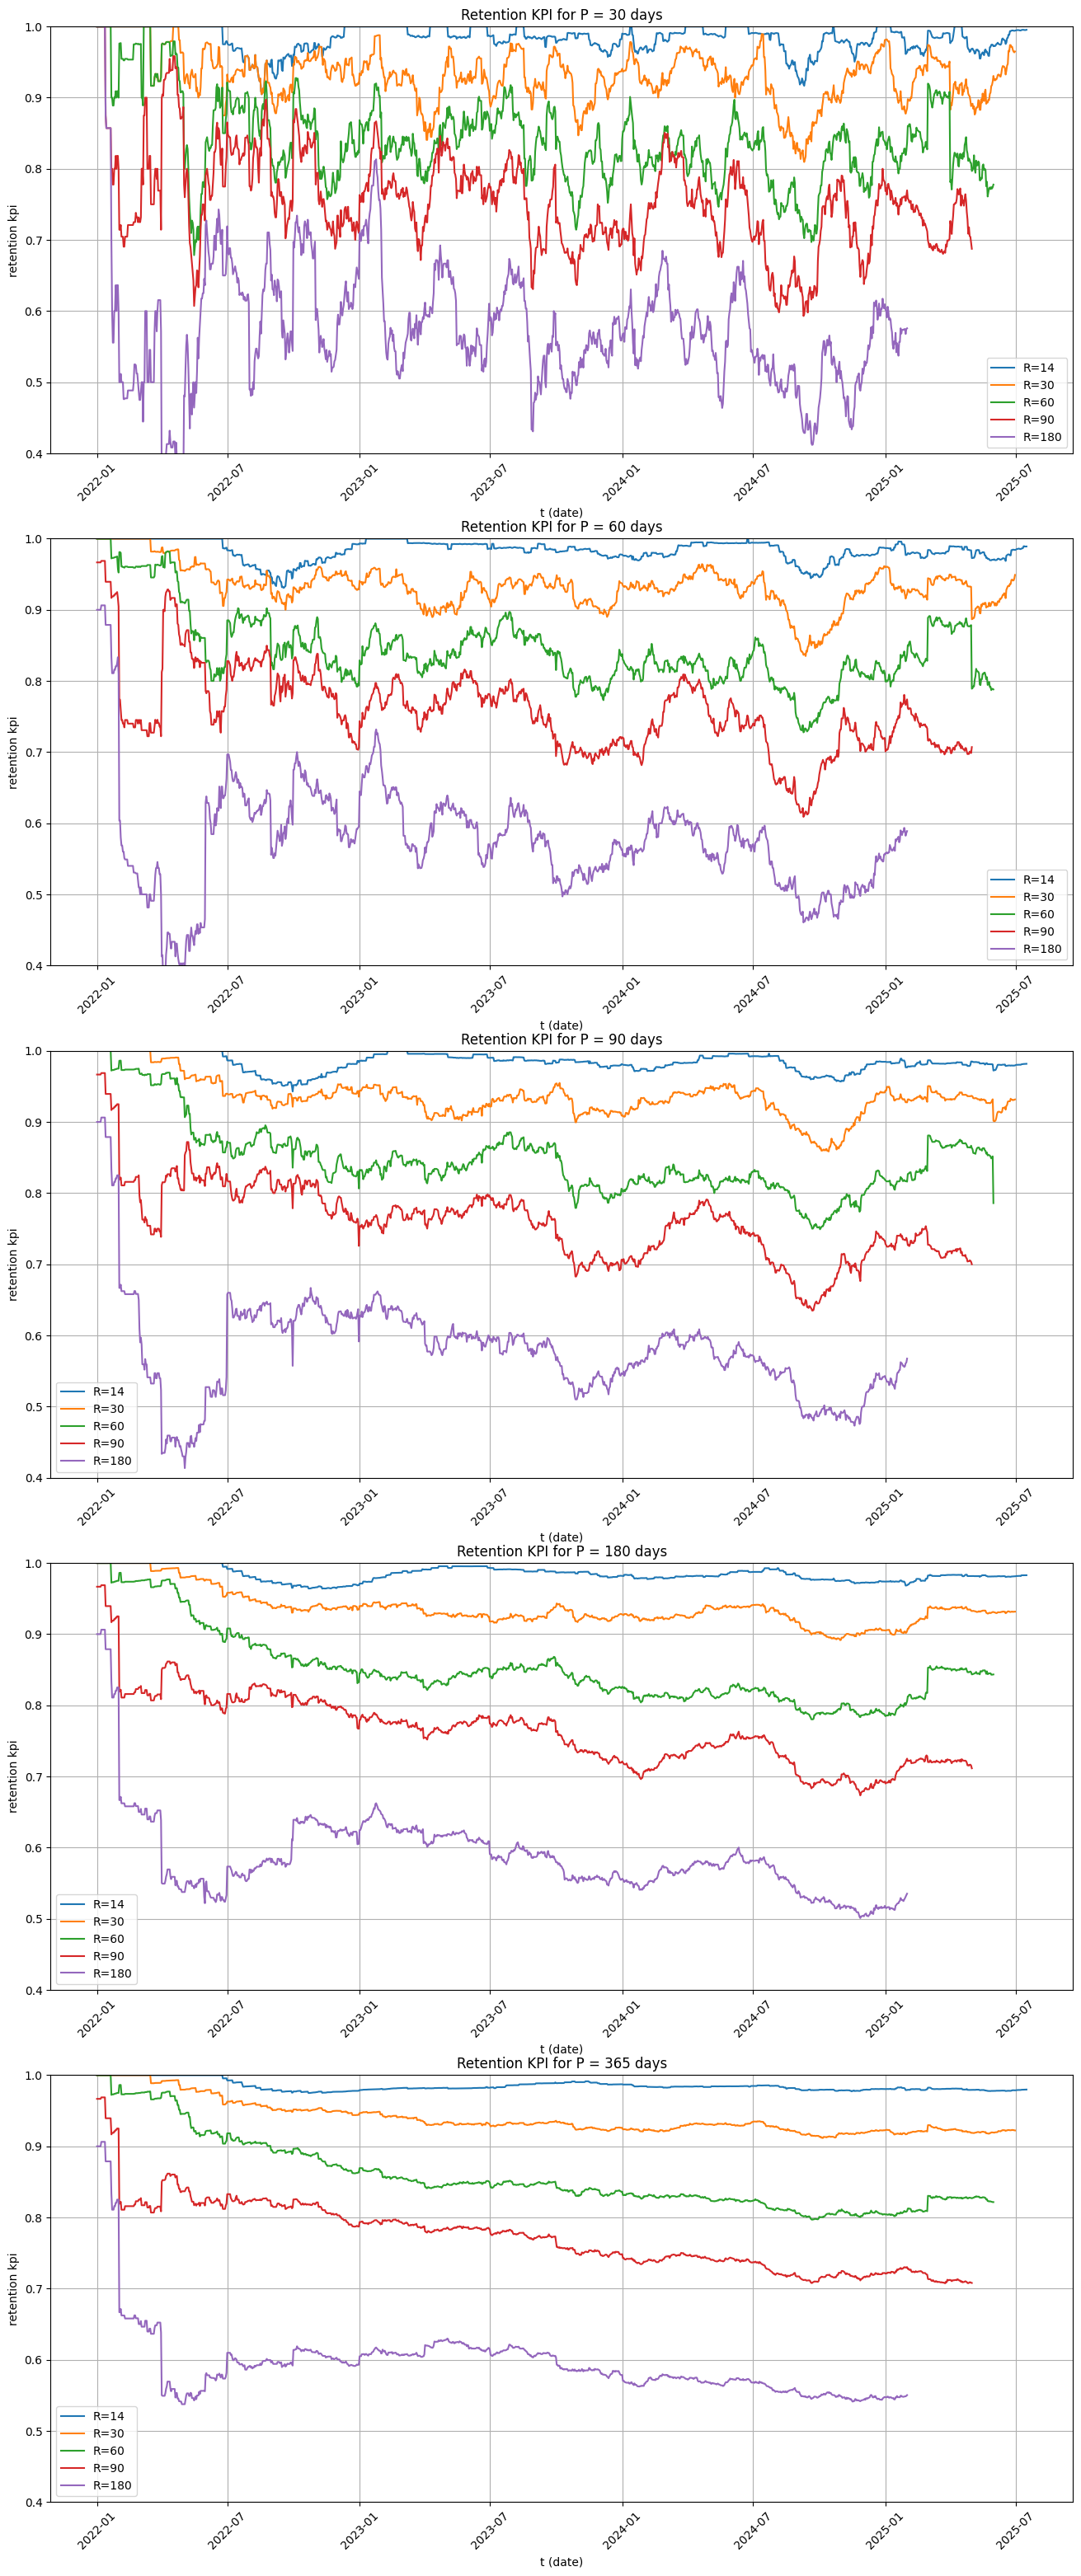

In [13]:
fig, axes = plt.subplots(len(Ps), 1, figsize=(16, 6*6.5))
for i in range(len(Ps)):
    axes[i].plot(data[14][Ps[i]][:,0], data[14][Ps[i]][:,1],linestyle='-')
    axes[i].plot(data[30][Ps[i]][:,0], data[30][Ps[i]][:,1],linestyle='-')
    axes[i].plot(data[60][Ps[i]][:,0], data[60][Ps[i]][:,1],linestyle='-')
    axes[i].plot(data[90][Ps[i]][:,0], data[90][Ps[i]][:,1],linestyle='-')
    axes[i].plot(data[180][Ps[i]][:,0], data[180][Ps[i]][:,1],linestyle='-')
    axes[i].set_title('Retention KPI for P = ' + str(Ps[i]) + ' days')
    axes[i].set_xlabel('t (date)')
    axes[i].set_ylabel('retention kpi')
    axes[i].grid(True)
    axes[i].set_ylim([0.4, 1])
    # axes[i].set_xticks(rotation=45)  # You can also use 30, 60, etc.
    axes[i].tick_params(axis='x', labelrotation=45)
    # axes[i].set_tight_layout()
    axes[i].legend(['R=14','R=30','R=60','R=90','R=180'])

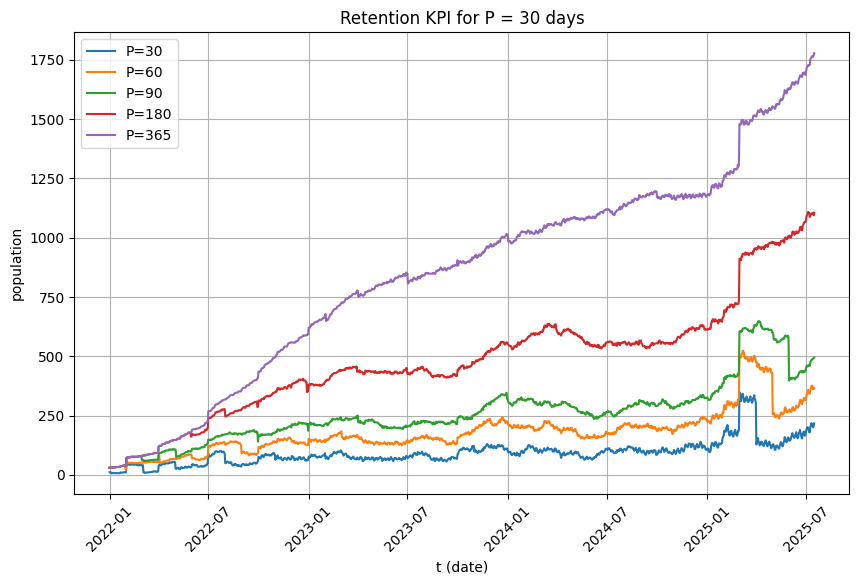

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
i = 0
legendData = []
for P in Ps:
    axes.plot(populations[14][P][:,0], populations[14][P][:,1],linestyle='-')
    legendData.append('P=' + str(P))
axes.set_title('Retention KPI for P = ' + str(Ps[i]) + ' days')
axes.set_xlabel('t (date)')
axes.set_ylabel('population')
axes.grid(True)
# axes[i].set_ylim([0.4, 1])
# axes[i].set_xticks(rotation=45)  # You can also use 30, 60, etc.
axes.tick_params(axis='x', labelrotation=45)
# axes[i].set_tight_layout()

axes.legend(legendData)